# Python Code to perform Fourier Optics

This is a port of the MATLAB code I have written to perform EM wave propagation to Python.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import widgets

## Defining classes

As in the MATLAB code, I have to define the classes for the Lens and Propagator. 

In [2]:
class Propagator:
    def __init__(self, L, wavelength, dx):
        self.L = L
        self.wavelength = wavelength
        self.dx = dx   
        self.M = L/dx+1
        self.x = np.arange(-L/2,L/2,self.dx)
        self.y = np.arange(-L/2,L/2,self.dx)
        self.X, self.Y = np.meshgrid(self.x, self.y)

    def pso(self, xangle, yangle, R1):
        xshift = R1*np.sin(np.radians(xangle))
        xshiftblocks = np.fix(xshift/self.dx)
        yshift = R1*np.sin(np.radians(yangle))
        yshiftblocks = np.fix(yshift/self.dx)
        u0 = np.zeros(self.M)
        u0[np.floor(self.M/2)-yshiftblocks,np.floor(self.M/2)-xshiftblocks] = 1;
        return u0
         
    
    def prop(self, u0, z):
        '''propagates source to focal plane'''
        k = 2*np.pi/self.wavelength
        fx = np.arange(-1/(2*self.dx),1/(2*self.dx),1/self.L)
        fy = np.arange(-1/(2*self.dx),1/(2*self.dx),1/self.L)
        Fx, Fy = np.meshgrid(fx,fy)
        H = np.exp(-1j*k*z*np.sqrt(1 - (self.wavelength*Fx)**2 - (self.wavelength*Fy)**2))
        H[Fx**2 + Fy**2 > 1/self.wavelength**2] = 0
        U0 = np.fft.fftshift(np.fft.fft2(np.fft.fftshift(u0)))
        U1 = H*U0
        u1 = np.fft.ifftshift(np.fft.ifft2(np.fft.ifftshift(U1)))
        return u1
    
    def backprop(self, u0, z):
        '''backpropagates'''
        return self.prop(u0, -z)
    
    

In [3]:
class FresnelPropagator(Propagator):
    def __init__(self, L, wavelength, dx):
        Propagator.__init__(self, L, wavelength, dx)
        
    def fresnelprop(self, u0, z):
        '''Performs Fresnel propagation'''
        k = 2*np.pi/self.wavelength
        fx = np.arange(-1/(2*self.dx),1/(2*self.dx),1/self.L)
        fy = np.arange(-1/(2*self.dx),1/(2*self.dx),1/self.L)
        Fx, Fy = np.meshgrid(fx,fy)
        U0 = np.fft.fftshift(np.fft.fft2(np.fft.fftshift(u0)))
        H = np.exp(-1j*np.pi*wavelength*(Fx**2 + Fy**2))
        u1 = np.fft.ifftshift(np.fft.ifft2(np.fft.fftshift(H*U0)))
        
        return u1
        
        


In [4]:
class Lens(Propagator):
    def __init__(self, L, wavelength, dx):
        Propagator.__init__(self, L, wavelength, dx)
        self.r = np.sqrt(self.X**2+self.Y**2)
        
    def phaseprofile(self, coeffs, antenna_r):
        phase0 = 0
        r1 = self.r/antenna_r
        for i in len(coeffs):
            phase0 = phase0 + coeffs(i)*(r1**(2*i))
        phase0[self.r > antenna_r] = 0
        return phase0

    def makephaselens(self, coeffs, antenna_r, padding):
        phase0 = self.phaseprofile(coeffs, antenna_r)
        lens = np.exp(1j*phase0)
        if padding == 0:
            lens[self.r > antenna_r] = 0
        return lens
            
    def lenspropagate(self, u0, lens, z1, z2):
        b4lens = self.prop(u0, z1)
        afterlens = b4lens*lens
        u1 =  self.prop(afterlens, z2)
        return u1
    
    def makecplens(self, z1, z2, antenna_r, padding):
        R1 = np.sqrt(self.X**2+self.Y**2+z1**2)
        R2 = np.sqrt(self.X**2+self.Y**2+z2**2)
        lens = np.exp(1j*(2*pi/self.wavelength)*(R1+R2))
        if padding == 0:
            lens[self.r > antenna_r] = 0
        elif padding == 1:
            lens[self.r > antenna_r] = 1
        return lens

        
        
    def cpthickness(self, z1, z2):
        R1 = np.sqrt(self.X**2+self.Y**2+z1^2)
        R2 = np.sqrt(self.X**2+self.Y**2+z2^2)
        thickness =(2*pi/self.wavelength)*(R1+R2)
        return thickness
        
        
    def makelensfromthickness(self, thickness, antenna_r, padding):
        lens = np.exp(1j*thickness)
        if padding == 0:
            lens[self.r > antenna_r] = 0
        elif padding == 1:
            lens[self.r > antenna_r] = 1
        return lens

        

In [22]:
separation_slider = widgets.FloatSlider(
    value=0.3e-3,
    min=0,
    max=1e-3,
    step=0.01e-3,
    description='Separation:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.5f',
)

slit_width_slider = widgets.FloatSlider(
    value=0.1e-3,
    min=0.1e-3,
    max=1e-3,
    step=0.01e-3,
    description='Slit Width: ',
    readout_format='.5f'
)

windowing = widgets.FloatSlider(
    value=0.5,
    min=0,
    max=1,
    description='Height:'
    
)


slit_type = widgets.Dropdown(
    options=['Double Slit', 'Single Slit', 'Circular Hole', 'Circular Obstacle', 'Ring hole'],
    description='Aperture',
    continous_upate=True
)

hole_radius_slider = widgets.FloatSlider(
    value=0.15e-3,
    min=0.15e-3,
    max=1e-3,
    step=0.01e-3,
    description='Hole Radius: ',
    readout_format='.5f'
)

bead_radius_slider = widgets.FloatSlider(
    value=0.15e-3,
    min=0.15e-3,
    max=1e-3,
    step=0.01e-3,
    description='Bead Radius: ',
    readout_format='.5f'
)


display(slit_type, slit_width_slider, separation_slider, hole_radius_slider, bead_radius_slider, windowing)
  


Dropdown(description='Aperture', options=('Double Slit', 'Single Slit', 'Circular Hole', 'Circular Obstacle', …

FloatSlider(value=0.0001, description='Slit Width: ', max=0.001, min=0.0001, readout_format='.5f', step=1e-05)

FloatSlider(value=0.0003, continuous_update=False, description='Separation:', max=0.001, readout_format='.5f',…

FloatSlider(value=0.00015, description='Hole Radius: ', max=0.001, min=0.00015, readout_format='.5f', step=1e-…

FloatSlider(value=0.00015, description='Bead Radius: ', max=0.001, min=0.00015, readout_format='.5f', step=1e-…

FloatSlider(value=0.5, description='Height:', max=1.0)

In [6]:
wavelength = 550e-9
dx = 0.1e-3
L = 5e-2

fp = FresnelPropagator(L, wavelength, dx)


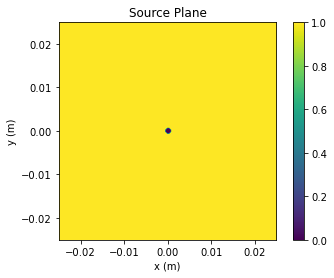

In [26]:
u0 = np.zeros(np.shape(fp.X))

if slit_type.value == 'Double Slit':
    separation = separation_slider.value
    slitwidth = slit_width_slider.value # also try 0.15 and 0.2 mm
    window = windowing.value*(L/2)
    u0[abs(fp.X) > separation/2] = 1
    u0[abs(fp.X) > separation/2+slitwidth] = 0
    u0[abs(fp.Y) > window] = 0
elif slit_type.value == 'Single Slit':
    slitwidth = slit_width_slider.value
    window = windowing.value*(L/2)
    u0[abs(fp.X) < slitwidth/2] = 1
    u0[abs(fp.X) > slitwidth/2] = 0
    u0[abs(fp.Y) > window] = 0
elif slit_type.value == 'Circular Hole':
    r = hole_radius_slider.value
    u0[fp.X**2+fp.Y**2 < r**2] = 1
elif slit_type.value == 'Circular Obstacle':
    r = bead_radius_slider.value
    u0[fp.X**2+fp.Y**2 > r**2] = 1
elif slit_type.value == 'Ring hole':
    r2 = hole_radius_slider.value
    r1 = bead_radius_slider.value
    if r2 > r1:
        u0[fp.X**2 + fp.Y**2 > r1**2] = 1
        u0[fp.X**2 + fp.Y**2 > r2**2] = 0
    else:
        print("Please do not input unphysical scenarios")
        u0[fp.X**2+fp.Y**2 < r1] = 1
    

plt.figure
plt.imshow(u0,origin='lower',extent=[fp.x[0],fp.x[-1],fp.y[0],fp.y[-1]])
plt.title("Source Plane")
plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.colorbar()

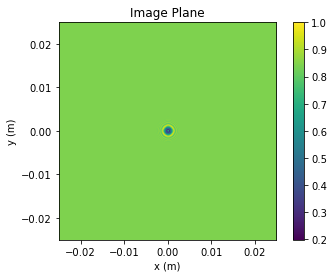

In [27]:
u1 = fp.fresnelprop(u0, 2)
u1 = np.abs(u1)/np.max(np.max(np.abs(u1)))

plt.figure
plt.imshow(u1,origin='lower',extent=[fp.x[0],fp.x[-1],fp.y[0],fp.y[-1]])
plt.title("Image Plane")
plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.colorbar()

u1cs = u1[round(len(u1)/2),:]

# plt.subplot(212)
# plt.plot(p.x, u1cs)

In [ ]:
plt.figure
plt.plot(fp.x, u1cs)
plt.grid()